# Проект для «Викишоп» с BERT

**Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Загрузка и подготовка данных

## Загрузка библиотек

In [1]:
#Общее
import numpy as np
import pandas as pd
import torch
import transformers
import tqdm
import spacy
import re
import matplotlib.pyplot as plt
import time

from tqdm import notebook
from tqdm import tqdm

#nltk
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

#sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

#catboost
from catboost import CatBoostClassifier

#lgbm
from lightgbm import LGBMClassifier

## Загрузка данных

In [2]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

## Общий обзор данных

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


**Обзор Unnamed: 0**

In [4]:
data['Unnamed: 0']

0              0
1              1
2              2
3              3
4              4
           ...  
159287    159446
159288    159447
159289    159448
159290    159449
159291    159450
Name: Unnamed: 0, Length: 159292, dtype: int64

In [5]:
data[data['Unnamed: 0'] == data.index]

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
6075,6075,"In fact, would anyone object to my changing of...",0
6076,6076,"She has plenty of real-world references, thank...",0
6077,6077,"""\n\n Wester Civ \n\nHello,\n I had gotten an...",0
6078,6078,"""\n\nPenis envy\nFrom Wikipedia, the free ency...",1


Очень похоже на остаток от индексов, после обработки датафрейма. Требуется удалить

In [6]:
data.drop('Unnamed: 0', axis=1, inplace=True)

**Дубликаты**

In [7]:
data.duplicated().sum()

0

**Пропуски**

In [8]:
data.isna().sum().sum()

0

**Баланс классов**

In [9]:
toxic_text = data.toxic[data.toxic==1].count()
non_toxic_text = data.toxic[data.toxic==0].count()

In [10]:
toxic_percent = 100 * toxic_text / data.shape[0]
f"Общий процент токсичных текстов: {toxic_percent:.2f}%"

'Общий процент токсичных текстов: 10.16%'

In [11]:
non_toxic_percent = 100 * non_toxic_text / data.shape[0]
f"Общий процент нетоксичных текстов: {non_toxic_percent:.2f}%"

'Общий процент нетоксичных текстов: 89.84%'

In [12]:
f"Соотношение токсичных к нетоксичным текстам: 1 к {round(non_toxic_percent / toxic_percent)}"

'Соотношение токсичных к нетоксичным текстам: 1 к 9'

Дисбаланс классов на лицо

## Нормализация и лемматизация текста

In [13]:
def clear_text(text_row):
    """
    text_row - строка для для нормализации
    возвращает нормализованную строку
    """    
    text_row = re.sub(r'[^a-zA-Z ]', ' ', text_row) 
    "".join(text_row.split()) 
    return " ".join(text_row.split()).lower()


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def lemmatize(text_row):
    """
    text_row - строка для лемматизации
    возвращает лемматизированную строку
    """
    doc = nlp(text_row)
    return " ".join([token.lemma_ for token in doc])

In [14]:
data['text'] = data.text.apply(clear_text)

In [15]:
%%time
lemmatized_texts = []
for row in range(len(data)):
    lemmatized_texts.append(lemmatize(data.loc[row, 'text']))

Wall time: 16min 6s


In [16]:
data['text'] = lemmatized_texts

In [17]:
data.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,more I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


## Вывод

Провели первичную подготовку признаков, использовали нормализацию текста и лемматизировали его с помощью библиотеки spaCy.

# Обучение моделей

## Подготовка признаков

Разделим на обучающую, валидационную и тестовую части

In [18]:
X = data['text']
y = data['toxic']

In [19]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.4, random_state=12345 )

In [20]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=12345 )

TF-IDF

In [21]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rasczack\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
X_train = count_tf_idf.fit_transform(X_train.values)

In [23]:
X_valid = count_tf_idf.transform(X_valid.values)
X_test = count_tf_idf.transform(X_test.values)

## Обучение

Обучим модели и запишем их:
- время на обучение
- метрику f1  на обучающем сете
- метрику f1 на валидационном сете
- лучший порог для метрики f1 на валидационном сете
- метрику f1 с подобранным порогом

In [24]:
classifiers = {
    'lr': ['LogisticRegression', LogisticRegression(solver='newton-cg', 
                                                    max_iter=2000,
                                                    class_weight='balanced',
                                                    random_state=12)],    
    'catboost': ['CatBoostClassifier', CatBoostClassifier(n_estimators=1000,
                                                          auto_class_weights='Balanced',
                                                          max_depth=4,
                                                          verbose=False)],
    
    'lgbm': ['LGBMClassifier', LGBMClassifier(boosting_type='goss',
                            n_estimators=1000,
                            class_weight='balanced',
                            learning_rate=0.05)]
}

classifiers_threshold = {
    'lr': 0,
    'catboost': 0,
    'lgbm': 0
}

In [25]:
# таблица для сохранения результатов
model_scores=pd.DataFrame(
    {'classifier': classifiers.keys(), 
     'valid_f1_score': np.zeros(len(classifiers)),
     'threshold': np.zeros(len(classifiers)),
     'th_f1_score': np.zeros(len(classifiers)),
     'fit_time': np.zeros(len(classifiers))}
)


In [26]:
def threshold_table_n_graph(model):
    """
    Функция считает precision, recall, accuracy в зависимости от порога классификации
    и рисует график кривой precision_Recall
    Возвращает лучшую метрику f1 и порог 
    """
    probabilities_valid = model.predict_proba(X_valid)
    predict_proba_valid = probabilities_valid[:, 1]
    best_f1 = 0
    for threshold in np.arange(0, 0.95, 0.05):
        predicted_valid = predict_proba_valid > threshold 
        precision = precision_score(y_valid, predicted_valid)
        recall = recall_score(y_valid, predicted_valid)
        accuracy = accuracy_score(y_valid, predicted_valid)
        f1 = f1_score(y_valid, predicted_valid)
        roc = roc_auc_score(y_valid, predict_proba_valid)
        print(
            "порог = {:.2f} | accuracy = {:.3f}, точность = {:.3f}, полнота = {:.3f}, f1 = {:.3f}, roc_auc = {:.3f}"
            .format(threshold, accuracy, precision, recall, f1, roc)
        )
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    

    precision, recall, thresholds = precision_recall_curve(y_valid, predict_proba_valid)
    
    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Кривая Precision-Recall')
    plt.show()
    return best_f1, best_threshold

LogisticRegression 

порог = 0.00 | accuracy = 0.104, точность = 0.104, полнота = 1.000, f1 = 0.188, roc_auc = 0.971
порог = 0.05 | accuracy = 0.462, точность = 0.162, полнота = 0.997, f1 = 0.278, roc_auc = 0.971
порог = 0.10 | accuracy = 0.646, точность = 0.226, полнота = 0.988, f1 = 0.368, roc_auc = 0.971
порог = 0.15 | accuracy = 0.753, точность = 0.293, полнота = 0.974, f1 = 0.451, roc_auc = 0.971
порог = 0.20 | accuracy = 0.820, точность = 0.363, полнота = 0.965, f1 = 0.527, roc_auc = 0.971
порог = 0.25 | accuracy = 0.857, точность = 0.418, полнота = 0.945, f1 = 0.579, roc_auc = 0.971
порог = 0.30 | accuracy = 0.887, точность = 0.478, полнота = 0.931, f1 = 0.632, roc_auc = 0.971
порог = 0.35 | accuracy = 0.909, точность = 0.536, полнота = 0.915, f1 = 0.676, roc_auc = 0.971
порог = 0.40 | accuracy = 0.924, точность = 0.587, полнота = 0.897, f1 = 0.709, roc_auc = 0.971
порог = 0.45 | accuracy = 0.933, точность = 0.629, полнота = 0.877, f1 = 0.733, roc_auc = 0.971
порог = 0.50 | accu

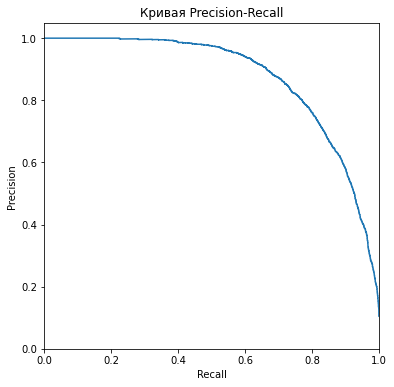

Время обучения модели составило 0.04 сек.


CatBoostClassifier 

порог = 0.00 | accuracy = 0.104, точность = 0.104, полнота = 1.000, f1 = 0.188, roc_auc = 0.962
порог = 0.05 | accuracy = 0.299, точность = 0.129, полнота = 0.998, f1 = 0.228, roc_auc = 0.962
порог = 0.10 | accuracy = 0.459, точность = 0.160, полнота = 0.991, f1 = 0.276, roc_auc = 0.962
порог = 0.15 | accuracy = 0.575, точность = 0.195, полнота = 0.984, f1 = 0.325, roc_auc = 0.962
порог = 0.20 | accuracy = 0.676, точность = 0.239, полнота = 0.973, f1 = 0.384, roc_auc = 0.962
порог = 0.25 | accuracy = 0.756, точность = 0.294, полнота = 0.960, f1 = 0.450, roc_auc = 0.962
порог = 0.30 | accuracy = 0.823, точность = 0.365, полнота = 0.944, f1 = 0.526, roc_auc = 0.962
порог = 0.35 | accuracy = 0.895, точность = 0.497, полнота = 0.909, f1 = 0.643, roc_auc = 0.962
порог = 0.40 | accuracy = 0.918, точность = 0.567, полнота = 0.882, f1 = 0.690, roc_auc = 0.962
порог = 0.45 | accuracy = 0.934, точность = 0.638, полнота = 0.855, f1 

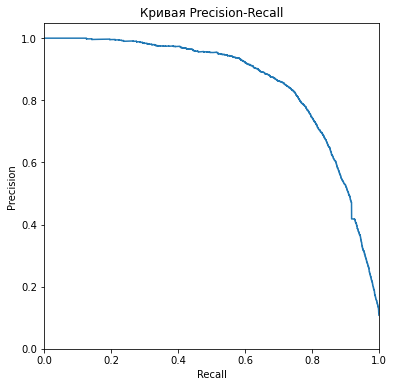

Время обучения модели составило 6.48 сек.


LGBMClassifier 

порог = 0.00 | accuracy = 0.104, точность = 0.104, полнота = 1.000, f1 = 0.188, roc_auc = 0.963
порог = 0.05 | accuracy = 0.664, точность = 0.233, полнота = 0.976, f1 = 0.377, roc_auc = 0.963
порог = 0.10 | accuracy = 0.764, точность = 0.301, полнота = 0.957, f1 = 0.458, roc_auc = 0.963
порог = 0.15 | accuracy = 0.819, точность = 0.358, полнота = 0.940, f1 = 0.519, roc_auc = 0.963
порог = 0.20 | accuracy = 0.855, точность = 0.412, полнота = 0.923, f1 = 0.569, roc_auc = 0.963
порог = 0.25 | accuracy = 0.881, точность = 0.463, полнота = 0.910, f1 = 0.614, roc_auc = 0.963
порог = 0.30 | accuracy = 0.900, точность = 0.512, полнота = 0.896, f1 = 0.652, roc_auc = 0.963
порог = 0.35 | accuracy = 0.915, точность = 0.557, полнота = 0.882, f1 = 0.682, roc_auc = 0.963
порог = 0.40 | accuracy = 0.931, точность = 0.623, полнота = 0.862, f1 = 0.724, roc_auc = 0.963
порог = 0.45 | accuracy = 0.939, точность = 0.660, полнота = 0.843, f1 = 0.

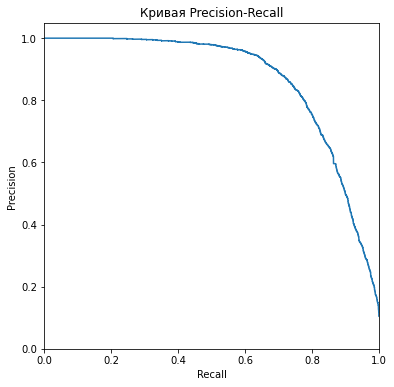

Время обучения модели составило 3.35 сек.




In [27]:
i=0

for key, items in classifiers.items():
    start = time.time()
    model = items[1]
    print(items[0], '\n')

    # Train, score n time
    model = model.fit(X_train, y_train)
    stop = time.time()
    delta_time = np.round((stop - start)/60, 2)
    model_scores.loc[i, 'fit_time'] = delta_time
    model_scores.loc[i, 'valid_f1_score'] = f1_score(y_valid, model.predict(X_valid))
    
    #порог классификации
    threshold, model_scores.loc[i, 'threshold'] = threshold_table_n_graph(model)
    model_scores.loc[i, 'th_f1_score'] = threshold
    classifiers_threshold[key] = threshold
    
    print(f"Время обучения модели составило {delta_time} сек.\n\n")
    i+=1

In [28]:
model_scores

,classifier,valid_f1_score,threshold,th_f1_score,fit_time
0,lr,0.747485,0.70,0.784320,0.04
1,catboost,0.754867,0.65,0.784431,6.48
2,lgbm,0.755875,0.70,0.792892,3.35


## Анализ моделей

Все CatBoost и LGBM на валидационной выборке показали результат в рамках техзадания. При подборе порога классификации все модели могут пройти порог метрики f1 = 0.75. 

Мы выберем модель LGBM, как показавшую не только лучшие результаты, но и более быструю чем CatBoost почти в 2 раза.

## Тестирование моделей

Проверим модель на тестовов выборке с подобранным порогом

In [29]:
best_model = classifiers['lgbm'][1]

In [30]:
best_model = best_model.fit(X_train, y_train)

In [31]:
predict = model.predict_proba(X_test)[:, 1] > classifiers_threshold['lgbm']

In [32]:
f"Значение метрики f1 на тестовой выборке у LGBM модели составило: {f1_score(y_test, predict):.2f}"

'Значение метрики f1 на тестовой выборке у LGBM модели составило: 0.78'

Хороший результат получился, модель можно рекомендовать

# Общий вывод

Мы подобрали модель на основе LGBM Classifier'а с параметрами (boosting_type='goss', n_estimators=1000, class_weight='balanced', learning_rate=0.05). Также подобрали порог классификации, улучшающий важную для заказчика метрику. Модель достигает результатов: f1 = 0.79 на трейне и 0.78 на тесте, что удовлетворяет условиям задания.

С другой стороны можно рекомендовать модель линейной классификации, как самую быструю, при подобранном пороге классификации данная модель будет превосходить нижнюю границу метрики, обучаяс на два порядка быстрее.